In [1]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#limiting the gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#loading the dataset
images=tf.data.Dataset.list_files('archive (1)/Train/Train/JPEGImages\\*.jpg')


In [4]:
#function for loading
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
images = images.map(load_image)


In [6]:
#image as numpy
images.as_numpy_iterator().next()

array([[[ 35,  12,   4],
        [ 34,  11,   3],
        [ 34,  11,   5],
        ...,
        [ 69,  75,  71],
        [ 60,  69,  64],
        [ 64,  73,  68]],

       [[ 28,   5,   0],
        [ 30,   7,   0],
        [ 31,   8,   2],
        ...,
        [132, 139, 132],
        [131, 141, 133],
        [100, 111, 103]],

       [[ 31,   8,   0],
        [ 33,  10,   2],
        [ 31,  11,   4],
        ...,
        [144, 154, 145],
        [133, 145, 135],
        [142, 154, 144]],

       ...,

       [[ 18,  15,  10],
        [ 21,  16,  12],
        [ 24,  17,  11],
        ...,
        [ 19,   9,   7],
        [ 21,  13,  10],
        [ 17,  14,   9]],

       [[ 24,  17,  11],
        [ 25,  18,  12],
        [ 26,  17,  10],
        ...,
        [ 20,  12,   9],
        [ 21,  16,  12],
        [ 17,  14,   7]],

       [[ 26,  19,  13],
        [ 25,  18,  12],
        [ 26,  17,  10],
        ...,
        [ 21,  13,  10],
        [ 22,  17,  13],
        [ 17,  14,   7]]

In [7]:
#image graph
i_g = images.batch(1).as_numpy_iterator()

In [8]:
plot_images = i_g.next()

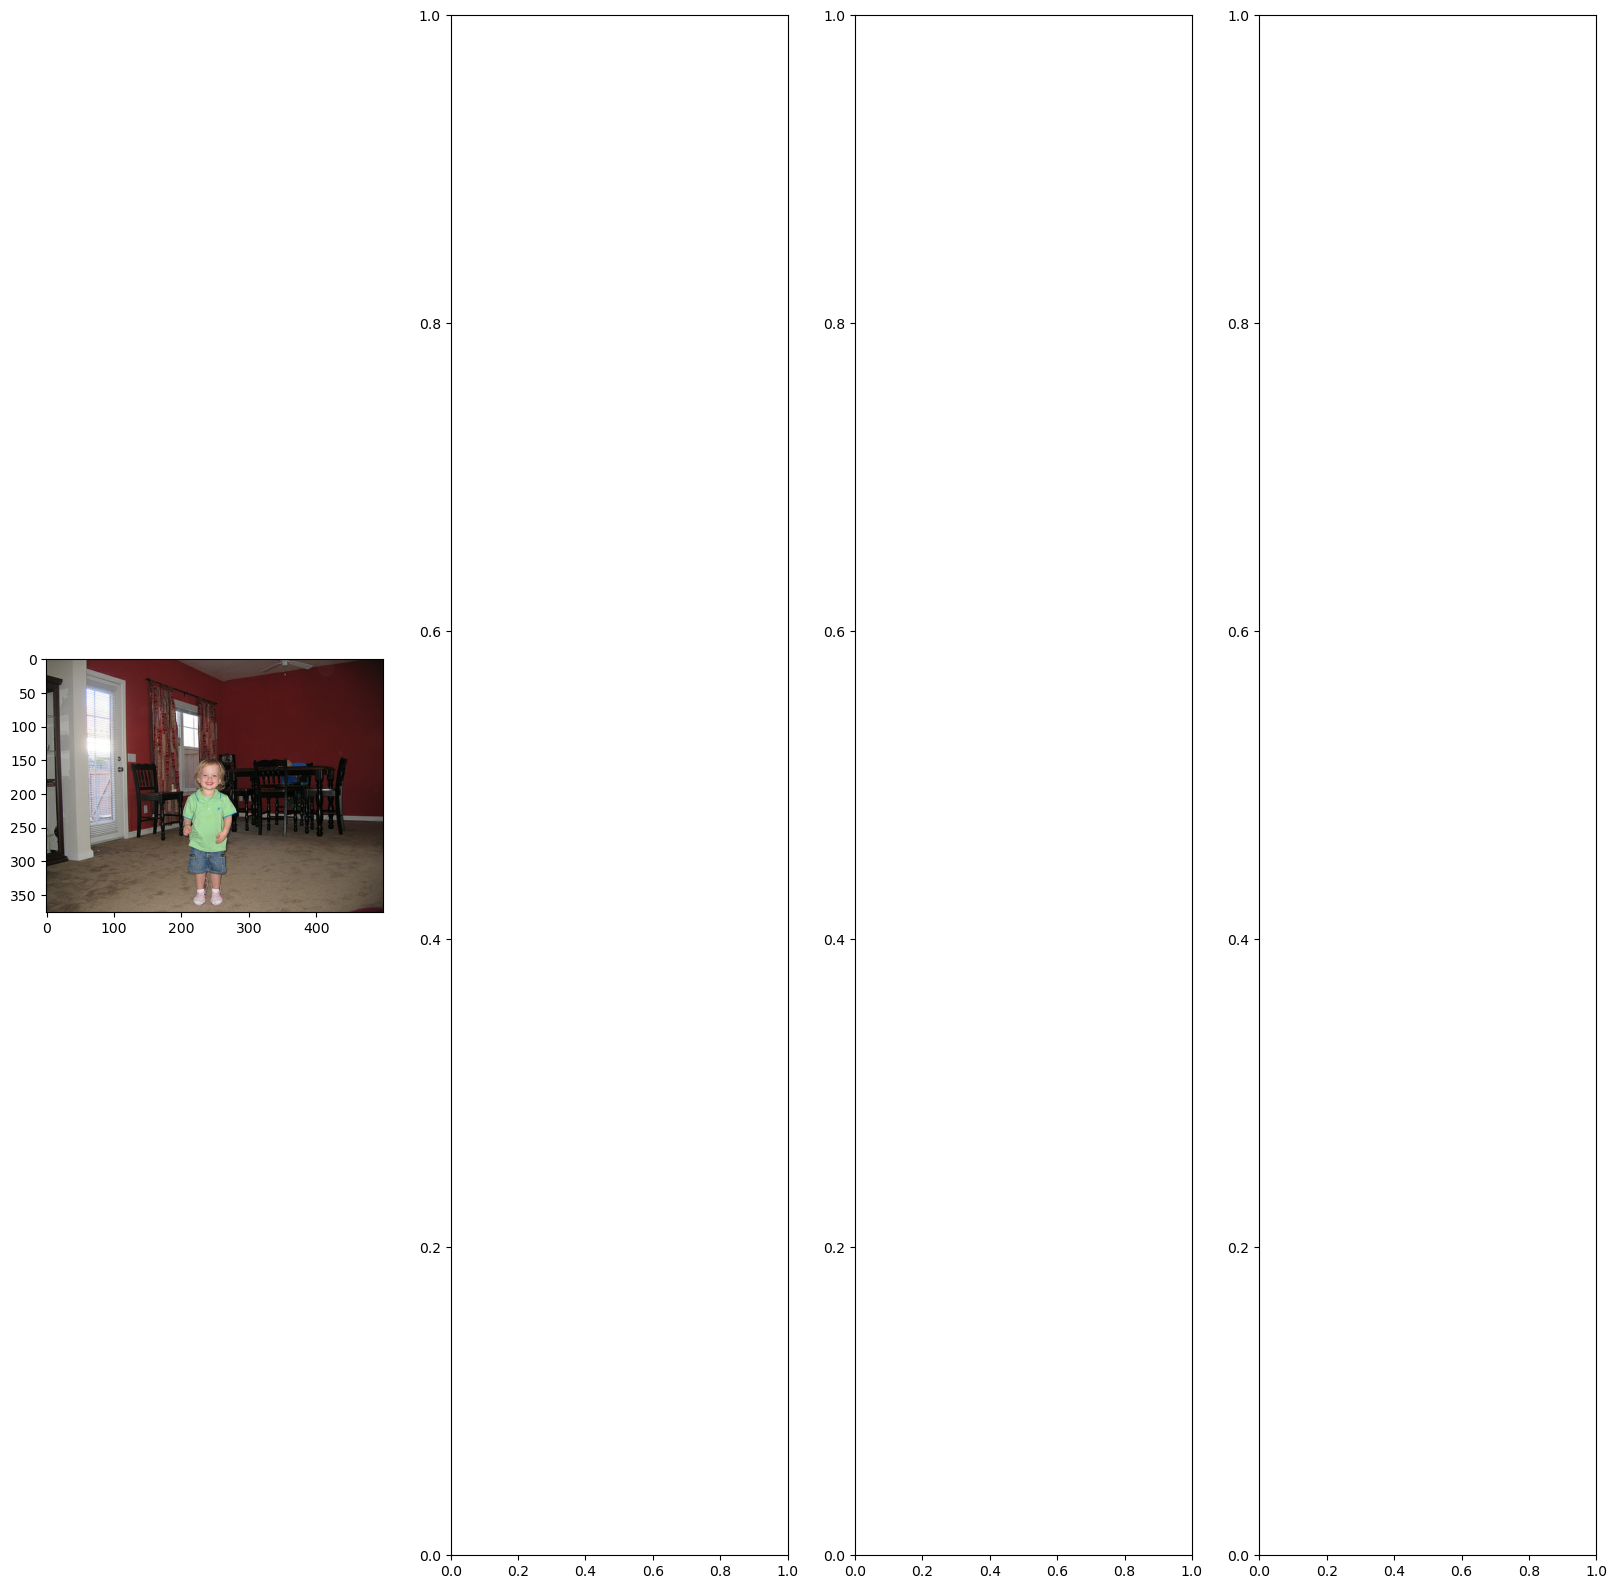

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [10]:
#tool for agumentation
import albumentations as alb

In [11]:
aug = alb.Compose([
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [12]:
#loading image 1
img = cv2.imread(os.path.join('archive (1)','train','train','JPEGImages','image (1).jpg'))

In [13]:
#minidom for reading xml file
from xml.dom import minidom

In [14]:
#loadinf first xml file
file = minidom.parse('archive (1)\Train\Train\Annotations\image (1).xml')

In [15]:
#extracting the coordinates of person
coords = [0,0,0,0]
coords[0]=file.getElementsByTagName('xmin')[0].firstChild.nodeValue
coords[1]=file.getElementsByTagName('ymin')[0].firstChild.nodeValue
coords[2]=file.getElementsByTagName('xmax')[0].firstChild.nodeValue
coords[3]=file.getElementsByTagName('ymax')[0].firstChild.nodeValue

In [16]:
#dividing by width ans height
width=file.getElementsByTagName('width')[0].firstChild.nodeValue
height=file.getElementsByTagName('height')[0].firstChild.nodeValue
coords[0]=int(coords[0])/int(width)
coords[1]=int(coords[1])/int(height)
coords[2]=int(coords[2])/int(width)
coords[3]=int(coords[3])/int(height)

In [17]:
#coordinates 
coords

[0.316, 0.09954751131221719, 0.578, 0.3778280542986425]

In [18]:
#runing augmentation function
augmented = aug(image=img, bboxes=[coords], class_labels=['pedestrain'])

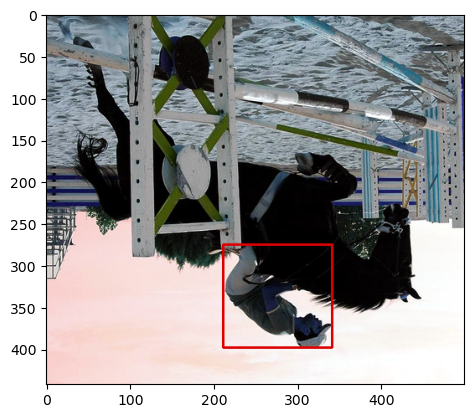

In [19]:
#puting rectangular box from coord on images
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [500,442]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [500,442]).astype(int)), 
                    (220,0,0), 2)

plt.imshow(augmented['image'])

In [20]:
for partition in ['Train','Test']: 
    for image in os.listdir(os.path.join('archive (1)', partition, partition, 'JPEGImages')):
        img = cv2.imread(os.path.join('archive (1)', partition, partition, 'JPEGImages', image))

        coords = [0,0,0.00001,0.00001]
        file = minidom.parse(fr'archive (1)\{partition}\{partition}\Annotations\{image.split(".")[0]}.xml')
        coords[0]=file.getElementsByTagName('xmin')[0].firstChild.nodeValue
        coords[1]=file.getElementsByTagName('ymin')[0].firstChild.nodeValue
        coords[2]=file.getElementsByTagName('xmax')[0].firstChild.nodeValue
        coords[3]=file.getElementsByTagName('ymax')[0].firstChild.nodeValue
        width=file.getElementsByTagName('width')[0].firstChild.nodeValue
        height=file.getElementsByTagName('height')[0].firstChild.nodeValue
        coords[0]=int(coords[0])/int(width)
        coords[1]=int(coords[1])/int(height)
        coords[2]=int(coords[2])/int(width)
        coords[3]=int(coords[3])/int(height)

        try: 
            for x in range(10):
                augmented = aug(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                ann= {}
                ann['image'] = image

                if os.path.exists(1):
                    if len(augmented['bboxes']) == 0: 
                        ann['bbox'] = [0,0,0,0]
                        ann['class'] = 0 
                    else: 
                        ann['bbox'] = augmented['bboxes'][0]
                        ann['class'] = 1
                else: 
                    ann['bbox'] = [0,0,0,0]
                    ann['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(ann, f)

        except Exception as e:
            print(e)

ZeroDivisionError: division by zero

In [21]:
#loading the train images
tr_i = tf.data.Dataset.list_files('aug_data\\Train\\images\\*.jpg', shuffle=False)
tr_i = tr_i.map(load_image)
tr_i = tr_i.map(lambda x: tf.image.resize(x, (120,120)))
tr_i = tr_i.map(lambda x: x/255)
#loading the test images
test_imag = tf.data.Dataset.list_files('aug_data\\Test\\images\\*.jpg', shuffle=False)
test_imag = test_imag.map(load_image)
test_imag = test_imag.map(lambda x: tf.image.resize(x, (120,120)))
test_imag = test_imag.map(lambda x: x/255)

tr_i.as_numpy_iterator().next()

array([[[0.7706427 , 0.71842045, 0.6634205 ],
        [0.59806377, 0.5458415 , 0.49352124],
        [0.48669398, 0.43963516, 0.3898966 ],
        ...,
        [0.28555474, 0.27747476, 0.24879554],
        [0.38764685, 0.368039  , 0.3458003 ],
        [0.44797692, 0.43314037, 0.39042512]],

       [[0.6813562 , 0.6345915 , 0.5717484 ],
        [0.63664216, 0.5898774 , 0.52703434],
        [0.6415196 , 0.6062255 , 0.54720587],
        ...,
        [0.353554  , 0.34569454, 0.29854584],
        [0.42222857, 0.4034054 , 0.36311093],
        [0.44049767, 0.39379016, 0.33401883]],

       [[0.59302825, 0.56557727, 0.49498907],
        [0.56437904, 0.53104573, 0.4633987 ],
        [0.6807462 , 0.6454521 , 0.5787854 ],
        ...,
        [0.37856546, 0.35818157, 0.29667553],
        [0.61168236, 0.578104  , 0.51286703],
        [0.67207223, 0.6201115 , 0.54493445]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.997127  , 0

In [22]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [23]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [24]:
len(tr_i), len(train_labels), len(test_imag), len(test_labels)

(9440, 9440, 870, 870)

In [25]:
train = tf.data.Dataset.zip((tr_i, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_imag, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [26]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2932, 0.066 , 0.6772, 0.68  ],
        [0.318 , 0.    , 0.72  , 0.789 ],
        [0.45  , 0.2693, 0.622 , 0.5864],
        [0.4087, 0.3552, 0.5825, 0.9346],
        [0.624 , 0.216 , 0.82  , 1.    ],
        [0.026 , 0.    , 0.426 , 0.7065],
        [0.276 , 0.024 , 0.783 , 0.728 ],
        [0.104 , 0.1893, 0.362 , 0.936 ]], dtype=float16))

In [27]:
data_samples = train.as_numpy_iterator()

In [28]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


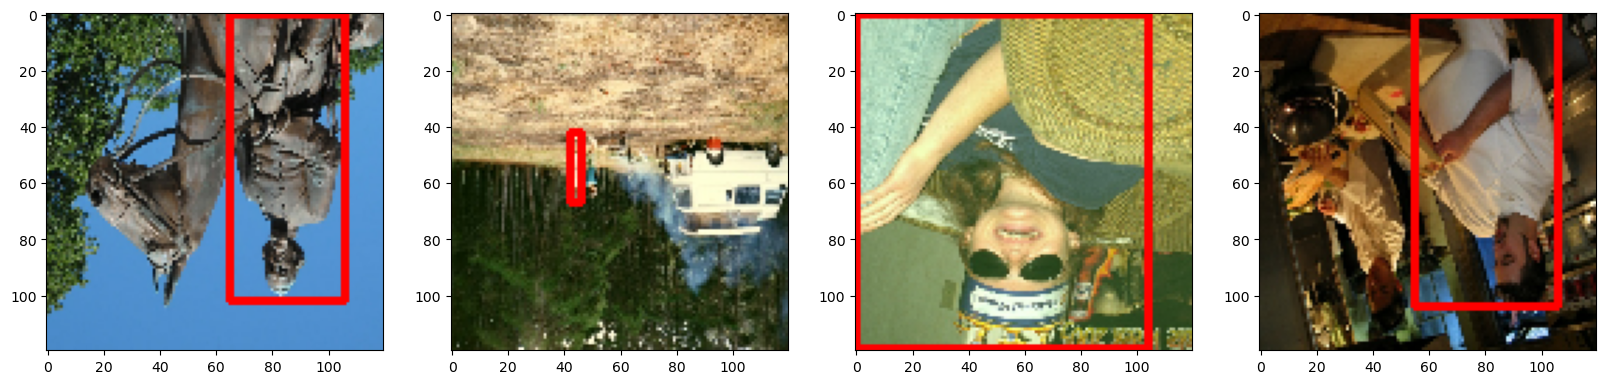

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [31]:
vgg = VGG16(include_top=False)

In [32]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [33]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [40]:
humantracker = build_model()

In [42]:
humantracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [36]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [37]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [38]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [44]:
class HumanTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [47]:
model = HumanTracker(humantracker)
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss


In [50]:
model.compile(opt, classloss, regressloss)
logdir='logs'

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [53]:
hist = model.fit(train, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
1180/1180 [==============================] - 262s 212ms/step - total_loss: 0.0816 - class_loss: 2.5108e-07 - regress_loss: 0.0816
Epoch 2/10
1180/1180 [==============================] - 127s 104ms/step - total_loss: 0.0712 - class_loss: 1.6245e-07 - regress_loss: 0.0712
Epoch 3/10
1180/1180 [==============================] - 118s 96ms/step - total_loss: 0.0627 - class_loss: 9.8378e-08 - regress_loss: 0.0627
Epoch 4/10
1180/1180 [==============================] - 118s 96ms/step - total_loss: 0.0511 - class_loss: 7.7156e-08 - regress_loss: 0.0511
Epoch 5/10
1180/1180 [==============================] - 123s 101ms/step - total_loss: 0.0410 - class_loss: 3.7676e-08 - regress_loss: 0.0410
Epoch 6/10
1180/1180 [==============================] - 129s 97ms/step - total_loss: 0.0322 - class_loss: 2.2371e-08 - regress_loss: 0.0322
Epoch 7/10
1180/1180 [==============================] - 211s 175ms/step - total_loss: 0.0377 - class_loss: 1.0599e-08 - regress_loss: 0.0377
Epoch 8/10
1180/

In [ ]:
hist.history

In [54]:
test_data = test.as_numpy_iterator()

In [55]:
test_sample = test_data.next()

In [56]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 175ms/step


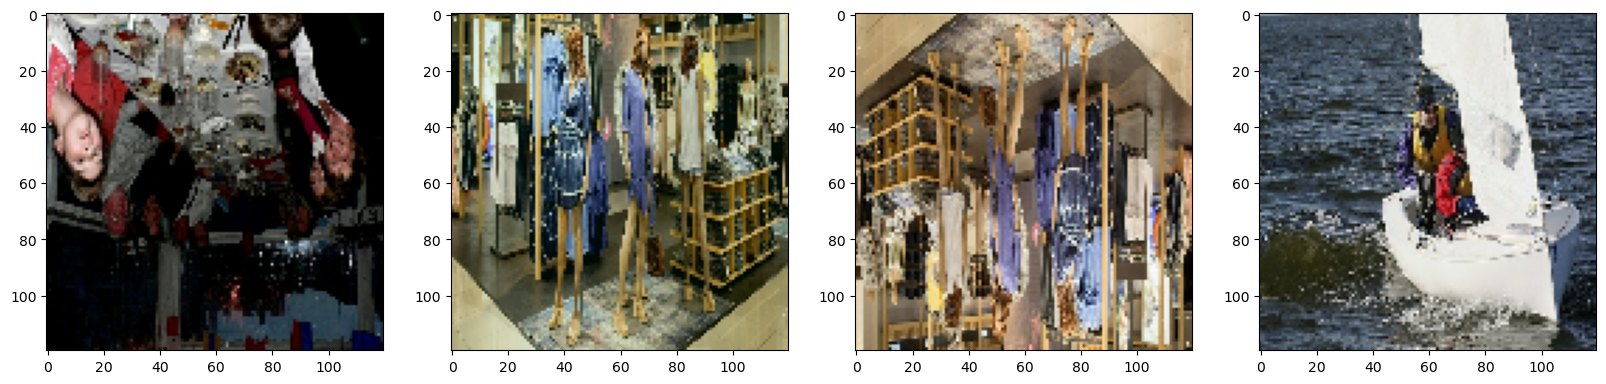

In [57]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [58]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')

In [59]:
from tensorflow.keras.models import load_model
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = humantracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    print(yhat[0])
    
    if yhat[0] == 1: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Human', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()